In [1]:
%matplotlib inline


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



Next three cells contains function to create separate Val/Test/whatever data in a form that ImageFolder loves, not fully automatic.. padhke use karna use

In [ ]:
# data_dir = 'crowdai'
raasta_train = os.path.join(data_dir, 'mini_train')
raasta_val = os.path.join(data_dir, 'mini_val')
# dirs_in_folder = [d for d in os.listdir(raasta) if os.path.isdir(os.path.join(raasta, d))]
dirs_in_train_folder = os.walk(raasta_train).next()[1]

In [ ]:
os.walk(raasta_train+'/c_0').next()[2].__class__

In [ ]:
for directori in dirs_in_train_folder:
    if not os.path.exists(os.path.join(raasta_val, directori)):
        os.makedirs(os.path.join(raasta_val, directori))
    
    if not (os.walk(os.path.join(raasta_val, directori)).next()[2]):
        current_dir  = os.path.join(raasta_train, directori)

        current_class_files = os.walk(current_dir).next()[2]
        current_class_files_count = len(current_class_files)

        val_files_count = current_class_files_count//5
        indices_to_move = random.sample(range(current_class_files_count), val_files_count)
        
        for i in indices_to_move:
            os.rename(os.path.join(raasta_train, directori, current_class_files[i]), 
                      os.path.join(raasta_val, directori, current_class_files[i]))
            


In [3]:
# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'crowdai'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



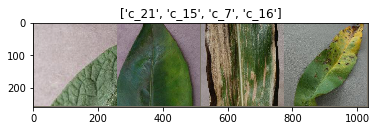

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving (deep copying) the best model

In the following, parameter ``lr_scheduler(optimizer, epoch)``
is a function  which modifies ``optimizer`` so that the learning
rate is changed according to desired schedule.



In [5]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

Learning rate scheduler
^^^^^^^^^^^^^^^^^^^^^^^
Let's create our learning rate scheduler. We will exponentially
decrease the learning rate once every few epochs.



In [10]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=15):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 38)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
LR is set to 0.001
train Loss: 0.5655 Acc: 0.4056
val Loss: 0.1965 Acc: 0.7667

Epoch 1/49
----------
train Loss: 0.3307 Acc: 0.6206
val Loss: 0.1200 Acc: 0.8548

Epoch 2/49
----------
train Loss: 0.2332 Acc: 0.7389
val Loss: 0.0855 Acc: 0.9095

Epoch 3/49
----------
train Loss: 0.1873 Acc: 0.7873
val Loss: 0.0762 Acc: 0.9024

Epoch 4/49
----------
train Loss: 0.1470 Acc: 0.8350
val Loss: 0.0491 Acc: 0.9381

Epoch 5/49
----------
train Loss: 0.1354 Acc: 0.8322
val Loss: 0.0473 Acc: 0.9405

Epoch 6/49
----------
train Loss: 0.1274 Acc: 0.8538
val Loss: 0.0553 Acc: 0.9429

Epoch 7/49
----------
train Loss: 0.1066 Acc: 0.8811
val Loss: 0.0928 Acc: 0.9095

Epoch 8/49
----------
train Loss: 0.1026 Acc: 0.8828
val Loss: 0.0611 Acc: 0.9286

Epoch 9/49
----------
train Loss: 0.1152 Acc: 0.8589
val Loss: 0.0477 Acc: 0.9381

Epoch 10/49
----------
train Loss: 0.0892 Acc: 0.8982
val Loss: 0.0799 Acc: 0.9214

Epoch 11/49
----------
train Loss: 0.0712 Acc: 0.9198
val Loss: 0.0

In [14]:
import cPickle

In [15]:
f = open('DenseNet_01.p','wb')

In [16]:
cPickle.dump(model_ft, f)

In [17]:
f.close()

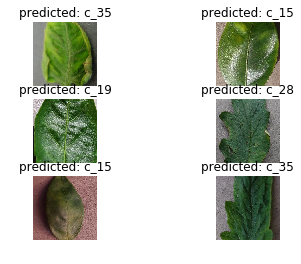

In [9]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [11]:
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 38)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.6936 Acc: 0.3129
val Loss: 0.3588 Acc: 0.6714

Epoch 1/24
----------
train Loss: 0.4879 Acc: 0.4886
val Loss: 0.2673 Acc: 0.7286

Epoch 2/24
----------
train Loss: 0.4103 Acc: 0.5734
val Loss: 0.1815 Acc: 0.7952

Epoch 3/24
----------
train Loss: 0.3544 Acc: 0.6286
val Loss: 0.1691 Acc: 0.8238

Epoch 4/24
----------
train Loss: 0.3344 Acc: 0.6308
val Loss: 0.1402 Acc: 0.8238

Epoch 5/24
----------
train Loss: 0.3106 Acc: 0.6564
val Loss: 0.1372 Acc: 0.8310

Epoch 6/24
----------
train Loss: 0.2783 Acc: 0.6883
val Loss: 0.1225 Acc: 0.8714

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.2413 Acc: 0.7361
val Loss: 0.1105 Acc: 0.8833

Epoch 8/24
----------
train Loss: 0.2459 Acc: 0.7497
val Loss: 0.1055 Acc: 0.8667

Epoch 9/24
----------
train Loss: 0.2482 Acc: 0.7292
val Loss: 0.1133 Acc: 0.8667

Epoch 10/24
----------
train Loss: 0.2397 Acc: 0.7452
val Loss: 0.1059 Acc: 0.8667

Epoch 11/24
----------
train Loss: 0.2415 Acc: 

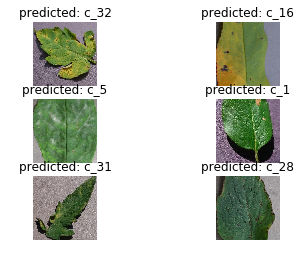

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()